# Finding the Number of New Song Listens per Month

## Modules

In [1]:
import pandas as pd
import numpy as np
import json
import ast

## Function Converting String Dictionaries to Literal Dictionaries

The JSON file containing the personal library information is a JSON file with nested objects. When the file is read, the entries are returned as string representations of a Python dictionary. This function is used to convert those string dictionaries to literal dictionaries and put it into an appropriate Pandas DataFrame format. 

In [2]:
def strDictsToDF(strDicts): 
    """
    Makes a new Pandas Dataframe object
    from the literal interpretation of another Dataframe
    containing string representations of Python dictionaries.
    To be used when parsing the YourLibrary.json
    Input: DataFrame of dictionaries represented as strings
    Output: DataFrame created from the literal interpretation of those string dictionaries
                 as actual Python dictionaries. 
    """
    for i in range (0, len(strDicts)):
        # The ast module allows literal interpretation of the string dictionaries
        temp_dict = ast.literal_eval(str(strDicts.loc[i][0]))
        
        # This is to find the dictionary keys which will be the column names.  
        # However, 
        if i == 0: 
            try:
                output = pd.DataFrame(columns=temp_dict.keys())
            except:
                print("An exception occurred: Object of Nonetype found in first position")
                return
            
        # Converts the dictionary values into literals and puts them into a dataframe row
        try: 
            output.loc[i] = temp_dict.values()
        except:
            print("An exception occurred: Object of Nonetype found before expected end")
            break
    return output; 

## JSON Filepaths

These two filepaths are for the two JSON files containing the required information to find new song listens each month. 

In [3]:
streamingPath = 'my_spotify_data\MyData\StreamingHistory0.json'
libraryPath = 'my_spotify_data\MyData\YourLibrary.json'

## Read the streaming history JSON file

In [4]:
dataStream = pd.read_json(streamingPath)
dataStream['minsPlayed'] = dataStream['msPlayed']/60000
dataStream['UniqueID'] = dataStream['artistName'] + ':' + dataStream['trackName']

dataStream.head(5)

,endTime,artistName,trackName,msPlayed,minsPlayed,UniqueID
0,2020-09-28 08:07,Hikaru Utada,Automatic - Johnny Vicious Remix,225017,3.750283,Hikaru Utada:Automatic - Johnny Vicious Remix
1,2020-09-28 18:59,Past Gas by Donut Media,The Murder of Racing Legend Mickey Thompson Pt.1,1587110,26.451833,Past Gas by Donut Media:The Murder of Racing L...
2,2020-09-29 21:19,Mamak Sessions,"Episode 66 - From Giving Up, To Getting A NETF...",2934420,48.907000,"Mamak Sessions:Episode 66 - From Giving Up, To..."
3,2020-10-01 07:14,Mamak Sessions,"Episode 66 - From Giving Up, To Getting A NETF...",927154,15.452567,"Mamak Sessions:Episode 66 - From Giving Up, To..."
4,2020-10-01 14:47,Mamak Sessions,"Episode 66 - From Giving Up, To Getting A NETF...",91735,1.528917,"Mamak Sessions:Episode 66 - From Giving Up, To..."


## Read the nested your library JSON file containing multiple objects

The JSON file associated with the user's library is a JSON file with nested objects. There are several objects of varying length and can at some times be empty. In this code implementation, it's known that the object containing artists in a library is not empty. However, it is important to check for other objects if they are empty. This code is also only interested in the yourArtists section of the JSON file containing the library information. 

In [5]:
dataLibrary = pd.read_json(libraryPath, orient='index')

# The index entries for tracks, albums, shows, episodes, bannedTracks, other are as follows: 0, 1, 2, 3, 4, 5, 6, 7
yourArtists = strDictsToDF(pd.DataFrame(dataLibrary.iloc[0]))

## Processing the Data

Generate a new column in the yourArtists dataframe called, "UniqueID." This column is made by combining the artist and track columns with a semicolon splitting them. Then another column is made consisting of just the Spotify track URI, called, "track_uri."

In [6]:
yourArtists['UniqueID'] = yourArtists['artist'] + ':' + yourArtists['track']
yourArtists_uri = yourArtists['uri'].str.split(":", expand=True)
yourArtists['track_uri'] = yourArtists_uri[2]

Find all unique artist names found in the yourArtists dataframe that was created. This will be used later to compare between if a streamed item is a Podcast or not, this will help determine new monthly listens of songs. 

In [7]:
uniqueArtistNames = yourArtists['artist'].unique()

print(uniqueArtistNames)

['DJ Okawari' 'Deb Never' 'Daniel Caesar' 'Marc Rebillet' 'serin oh'
 'TOKiMONSTA' 'Ella Mai' 'KYLE' 'Nieman' 'Dumbfoundead' 'Aminé'
 'Porter Robinson' 'hushlush' 'Hermitude' 'Doja Cat' 'iri' 'Hikaru Utada'
 'ASIAN KUNG-FU GENERATION' 'Khalid' 'MALIYA' 'Jeremy Passion' 'Mat Zo'
 'Gavin Turek' 'Rina Sawayama' 'Kehlani' 'Indigo la End' 'MIKNNA' 'LOONA'
 'BUMKEY' 'HEIZE' 'Run River North' 'Hyolyn' 'TWICE' 'Lianne La Havas'
 'RADWIMPS' 'Flownn' 'BTS' 'King Princess' 'SHACHI' 'Tamia' 'Shawn Wasabi'
 'ネクライトーキー' "Snail's House" 'Andrés' 'Toploader' 'AUDREY NUNA'
 'Passion Pit' 'ALLMO$T' 'Lake Street Dive' 'Victoria Monét' 'Mahalia'
 'IO Echo' 'Carly Rae Jepsen' 'Louis The Child' 'mxmtoon' '88rising'
 'Kero Kero Bonito' 'Andrew Huang' 'SATICA' '112' 'autumn keys' 'AKMU'
 'Tyler, The Creator' 'Childish Gambino' 'ATARASHII GAKKO!' 'Awkwafina'
 'Drake' 'Nadine Lustre' 'UMI' 'Melissa Polinar' 'Florence + The Machine'
 'Lexie Liu' 'Covet' 'Afro Parker' 'Jay Park' 'Majid Jordan' 'Big Wild'
 'The Hea

Generate a master dataframe which is based on the streaming history dataframe. Then create two new columns called, "In Library" and "Podcast." In Library is a column that consists of either 0s or 1s, if both the master dataframe and yourArtists contain the same UniqueID, then that means the track that was streamed is already in the library. Next, the Podcast column is used to determine if the streamed item is a song or a podcast. The artistName column in the master dataframe is compared with the list of uniqueArtistNames found. The list of uniqueArtistNames only list musical artists. Finally, the columns of "album," "UniqueID," and "track_uri" from yourArtists are merged with the master dataframe. 

In [8]:
dataTableau = dataStream.copy()
dataTableau_len = len(dataTableau)
dataTableau['In Library'] = np.where(dataTableau['UniqueID'].isin(yourArtists['UniqueID'].tolist()), 1, 0)
dataTableau['Podcast'] = np.where(dataTableau['artistName'].isin(uniqueArtistNames.tolist()), 0, 1)
dataTableau = pd.merge(dataTableau, yourArtists[['album', 'UniqueID', 'track_uri']], how='left', on=['UniqueID'])

In order to determine new song listens, the columns of "In Library" and "Podcast" of a given entry must be, 0. Once an entry is determined to be a new listen of a song, then the month when the song was listened to is found and recorded. 

In [9]:
newListensMonthly = pd.DataFrame([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], 
                                 index=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 
                                 columns=['2020', '2021'])
totalMonthlyListens = pd.DataFrame([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], 
                                 index=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 
                                 columns=['2020', '2021'])
newListensPerc = pd.DataFrame([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]],
                              index=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
                              columns=['2020', '2021']).astype(float)

# Calculate how many new song listens occurred each month
for i in range(0, len(dataTableau)): 
    # End time expanded to [year, month, day hour:min]
    expandedTime = dataTableau['endTime'][i].split("-")
    if ((dataTableau['In Library'][i] == 0) and dataTableau['Podcast'][i] == 0): 
        newListensMonthly[expandedTime[0]][expandedTime[1]] = newListensMonthly[expandedTime[0]][expandedTime[1]] + 1
    elif (dataTableau['Podcast'][i] == 0): 
        if ( expandedTime[0] == '2020' ):
            totalMonthlyListens[expandedTime[0]][expandedTime[1]] = totalMonthlyListens[expandedTime[0]][expandedTime[1]] + 1
        elif( expandedTime[0] == '2021'): 
            totalMonthlyListens[expandedTime[0]][expandedTime[1]] = totalMonthlyListens[expandedTime[0]][expandedTime[1]] + 1
    else: 
        continue
        
for i in range(0, len(newListensPerc)):
    if not newListensMonthly['2020'][i] is 0: 
        newListensPerc['2020'][i] = (newListensMonthly['2020'][i]/totalMonthlyListens['2020'][i])*100
    if not newListensMonthly['2021'][i] is 0:     
        newListensPerc['2021'][i] = (newListensMonthly['2021'][i]/totalMonthlyListens['2021'][i])*100
    
totalMonthlyListens.rename(columns={'2020':'Total 2020', '2021':'Total 2021'}, inplace=True)  
newListensPerc.rename(columns={'2020': '% 2020', '2021': '% 2021'}, inplace=True)
newListensMonthly = pd.concat([newListensMonthly, totalMonthlyListens, newListensPerc], axis=1)
        
newListensMonthly.head(12)

C:\SPB_Data\.virtualenvs\Spotify_Visualization-uYrJ5R7Z\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C:\SPB_Data\.virtualenvs\Spotify_Visualization-uYrJ5R7Z\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars


,2020,2021,Total 2020,Total 2021,% 2020,% 2021
01,0,125,0,571,NaN,21.891419
02,0,83,0,641,NaN,12.948518
03,0,138,0,447,NaN,30.872483
04,0,75,0,517,NaN,14.506770
05,0,77,0,595,NaN,12.941176
06,0,61,0,583,NaN,10.463122
07,0,110,0,709,NaN,15.514810
08,0,85,0,503,NaN,16.898608
09,0,22,1,364,0.000000,6.043956
10,80,0,453,0,17.660044,NaN


Initially, the columns for the DataFrame newListensMonthly is the format of a string that looks like a two digit number. This format is useful when trying to count how many new listens per month occur but this will be changed in the code below which is nicer to display on a plot. 

In [10]:
newListensMonthly.rename(index={'01': 'Jan', '02': 'Feb', '03':'Mar', '04':'Apr', '05':'May',
                                 '06':'Jun', '07':'Jul', '08':'Aug', '09':'Sept', '10':'Oct', '11':'Nov', '12':'Dec'}, inplace=True)

## Plotting the Data

Plot a bar graph of new monthly song listens on Spotify for the given years on one plot.  

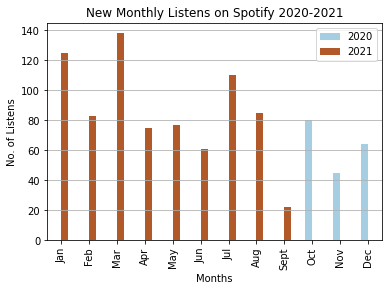

In [11]:
newListensMonthly.plot.bar(y=['2020', '2021'], xlabel='Months', ylabel='No. of Listens', 
                           title='New Monthly Listens on Spotify 2020-2021', colormap='Paired').grid(axis='y')

Plot a bar graph of the data from 2020.

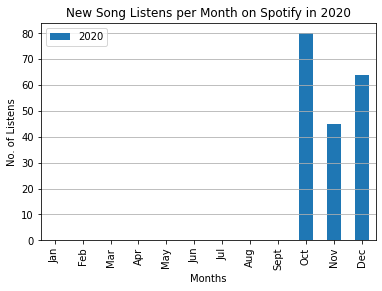

In [12]:
newListensMonthly.plot.bar(y='2020', xlabel='Months', ylabel='No. of Listens', title='New Song Listens per Month on Spotify in 2020').grid(axis='y')

Plot a bar graph of the data from 2021.

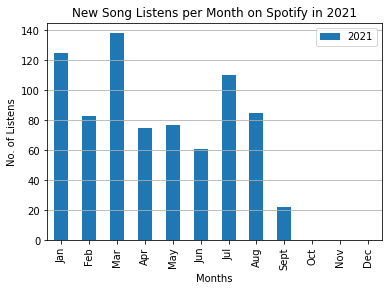

In [13]:
newListensMonthly.plot.bar(y='2021', xlabel='Months', ylabel='No. of Listens', title='New Song Listens per Month on Spotify in 2021').grid(axis='y')